<a href="https://colab.research.google.com/github/gabrielyuto/Exercises-object-oriented-programming/blob/master/Olist3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalação de pacotes

Vamos instalar os pacotes:

- `geopy`  (cálculo de distâncias entre coordenadas)
- `umap-learn` (redução da dimensionalidade usando o método umap)
- `kneed` para plotar o gráfico do cotovelo e achar o ponto


In [ ]:
!pip install geopy

# Dados

Para agilizar o processo, eu coloquei a base de dados no endereço a seguir, assim podemos baixar diretamente, e evitamos a demora em fazer o upload. O `wget` é usado para baixar o arquivo, e o `unzip` para descompactar.

In [ ]:
#!wget http://professor.ufabc.edu.br/~ronaldo.prati/archive.zip

In [ ]:
#!unzip archive.zip

Vamos agora refazer os passos da última aula, carregando os dados e unificando em um única tabela. Também convertemos os dados no formato data, calculamos a distância entre a origem e destino, e os tempos de entrega.

In [ ]:
import pandas as pd
import geopy.distance as gp
import numpy as np

*Carregar* as bases de dados

In [ ]:
df_item = pd.read_csv("olist_order_items_dataset.csv")
df_reviews = pd.read_csv("olist_order_reviews_dataset.csv")
df_orders = pd.read_csv("olist_orders_dataset.csv")
df_products = pd.read_csv("olist_products_dataset.csv")
df_geolocation = pd.read_csv("olist_geolocation_dataset.csv")
df_sellers = pd.read_csv("olist_sellers_dataset.csv")
df_order_pay = pd.read_csv("olist_order_payments_dataset.csv")
df_customers = pd.read_csv("olist_customers_dataset.csv")
df_category = pd.read_csv("product_category_name_translation.csv")

Unir todos em uma única tabela

In [ ]:
df = pd.merge(df_orders, df_item, on='order_id')
df = pd.merge(df,df_products, on='product_id')
df = pd.merge(df,df_sellers, on='seller_id')
df = pd.merge(df,df_customers, on='customer_id')
df = pd.merge(df,df_order_pay, on='order_id',how='right')
df = pd.merge(df,df_reviews, on='order_id')

In [ ]:
df.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'product_category_name',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'seller_zip_code_prefix',
       'seller_city', 'seller_state', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'review_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp'],
      dtype='object')

Nomes das colunas que envolvem data e hora

In [ ]:
date_columns = ['order_purchase_timestamp','order_approved_at', 'order_delivered_carrier_date',
                'order_delivered_customer_date', 'order_estimated_delivery_date', 'shipping_limit_date',
                'review_creation_date', 'review_answer_timestamp']

Faz a conversão dessas colunas para o format datetime

In [ ]:
df = df.assign(**df[date_columns].apply(pd.to_datetime))

Calcula o tempo de entrega, o tempo estimado, o tempo máximo de despacho, e o tempo de revisão da compra.

In [ ]:
df['deliver_time'] = df['order_delivered_customer_date'] - df['order_purchase_timestamp']
df['deliver_estimate'] = df['order_estimated_delivery_date'] - df['order_purchase_timestamp']
df['max_shipping_time'] = df['shipping_limit_date'] - df['order_purchase_timestamp']
df['review_time'] = df['review_creation_date'] - df['order_delivered_customer_date']

Calcula a distância entre a origem e o destino


In [ ]:
df_geolocation = df_geolocation.drop_duplicates()

In [ ]:
df_geo = df_geolocation.groupby('geolocation_zip_code_prefix').mean()

<ipython-input-12-d3617efe8ef2>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_geo = df_geolocation.groupby('geolocation_zip_code_prefix').mean()


In [ ]:
def geo_dist_zip(seller_zip_code_prefix, customer_zip_code_prefix):
    try:
        coord_seller = list(df_geo.loc[seller_zip_code_prefix])
        coord_customer = list(df_geo.loc[customer_zip_code_prefix])
        return gp.geodesic(coord_seller,coord_customer).km
    except:
        return

In [ ]:
df['distance'] = df.apply(lambda x: geo_dist_zip(x['seller_zip_code_prefix'],x['customer_zip_code_prefix']),axis=1)

Vamos fazer olhar os atributos numéricos da base de dados. A lista a seguir contém esses atributos.

In [ ]:
columns = ['price', 'freight_value', 'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'payment_installments', 'payment_value', 'distance', 'deliver_time',
       'deliver_estimate', 'max_shipping_time', 'review_time']

Finalmente, vamos converter os atributos de tempo de entraga para um valor numérico

In [ ]:
df = df.assign(**df[['deliver_time','deliver_estimate',
                     'max_shipping_time', 'review_time']].apply(lambda x: x.dt.total_seconds()/(24*60*60)))

# Coluna a ser predita

Vamos tentar criar um modelo para prever o `review_score` de cada compra. Vamos tratar como um problema binário, e vamos criar uma nova coluna com o valor `1` se o `review_score` é maior que três, e o valor `0` caso contrário.:

In [ ]:
df['review_score_binary'] =  df['review_score'].apply(lambda x: 1 if x > 3 else 0)

<Axes: >

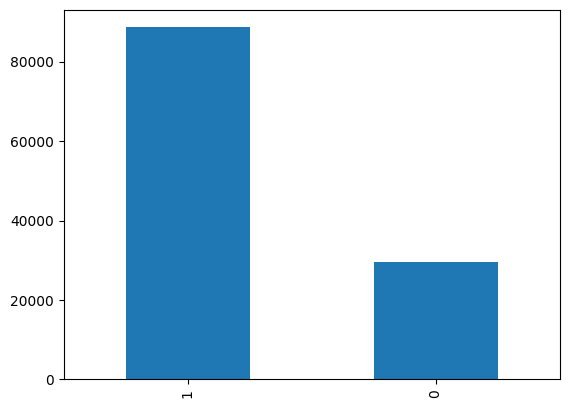

In [ ]:
df['review_score_binary'].value_counts().plot(kind='bar')

Agora vamos selecionar somente os dados completos para as colunas que vamos usar para fazer o modelo. Além disso, vamos separar os atributos alvos e os atributos preditores:

In [ ]:
data = df[columns + ['review_score_binary']].dropna(axis = 0, how = 'any')
X = data[columns]
Y = data['review_score_binary']

Vamos iniciar com árvore de decisão. Além do algoritmo de árvore de decisão, vamos importar também os métodos para fazer a validação cruzada, mostrar um relatório de classificação, e também o GridSearchCV, que é usado para avaliar vários parâmetros e comparar modelos.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

Inicialmente vamos declar o algoritmo da árvore de decisão sem nenhum parâmetro:

In [ ]:
dt = DecisionTreeClassifier()

Vamos agora fazer uma validação cruzada com 2 divisões. Cada divisão gera um subconjunto dos dados, que usamos para treinar e depois testar. Como estamos usando 2 divisões, os papeis em cada um deles é invertido a cada iteração

In [ ]:
kf = KFold(n_splits=2)
for train, test in kf.split(X):
  dt.fit(X.iloc[train],Y.iloc[train])
  predictions = dt.predict(X.iloc[test])
  print(classification_report(Y.iloc[test], predictions))

              precision    recall  f1-score   support

           0       0.34      0.37      0.36     13171
           1       0.80      0.78      0.79     43167

    accuracy                           0.69     56338
   macro avg       0.57      0.58      0.58     56338
weighted avg       0.70      0.69      0.69     56338

              precision    recall  f1-score   support

           0       0.34      0.38      0.36     12954
           1       0.81      0.78      0.80     43383

    accuracy                           0.69     56337
   macro avg       0.57      0.58      0.58     56337
weighted avg       0.70      0.69      0.69     56337



Como vimos em aula, temos vários critérios para construir a árvore. Vamos usar o `GridSearchCV` para fazer uma comparação, utilizando validação cruzada, dos diferentes critérios de split presentes no `sklearn`. Além disso, vamos calcular três diferentes medidas de desempenho: AUC, F1 e acurácia.

In [ ]:
parameters = {'criterion':('gini', 'entropy', 'log_loss')}
kf = KFold(n_splits=3)

grid_search = GridSearchCV(
        estimator=dt,
        param_grid=parameters,
        scoring = {"AUC": "roc_auc", "F-measure": "f1", "Accuracy": "accuracy"},
        return_train_score=False,
        cv=kf,
        refit=False
    ).fit(X,Y)

Os resultados das iterações estão armazenados em `cv_results_`. Vamos extrair alguns deles para ver o comparativo dos resultados do arquivo de teste. Na célula abaixo, selecionamos a média e o desvio padrão das $k$ execuções do $k$-fold das três medidas para cada critério de poda.

In [ ]:
results_dt = pd.DataFrame({ 'params' :  [v['criterion'] for v in grid_search.cv_results_['params']] ,
  'mean_test_AUC' :  grid_search.cv_results_['mean_test_AUC'],
  'mean_test_F-measure' :  grid_search.cv_results_['mean_test_F-measure'],
  'mean_test_Accuracy' :  grid_search.cv_results_['mean_test_Accuracy'],
  'std_test_AUC' :  grid_search.cv_results_['std_test_AUC'],
  'std_test_F-measure' :  grid_search.cv_results_['std_test_F-measure'],
  'std_test_Accuracy' :  grid_search.cv_results_['std_test_Accuracy']})

A tabela de resultados fica assim:

In [ ]:
results_dt

,params,mean_test_AUC,mean_test_F-measure,mean_test_Accuracy,std_test_AUC,std_test_F-measure,std_test_Accuracy
0,gini,0.583492,0.797354,0.692691,0.002192,0.002604,0.003121
1,entropy,0.581850,0.802038,0.697537,0.003080,0.000940,0.001632
2,log_loss,0.581697,0.801922,0.697386,0.003437,0.002332,0.003274


Vamos reorganizar a tabela para que fique mais legível. A função `melt` transforma a tebela de formato largo para o longo

In [ ]:
results_dt = pd.melt(results_dt,id_vars=['params'])

In [ ]:
results_dt

,params,variable,value
0,gini,mean_test_AUC,0.583492
1,entropy,mean_test_AUC,0.581850
2,log_loss,mean_test_AUC,0.581697
3,gini,mean_test_F-measure,0.797354
4,entropy,mean_test_F-measure,0.802038
5,log_loss,mean_test_F-measure,0.801922
6,gini,mean_test_Accuracy,0.692691
7,entropy,mean_test_Accuracy,0.697537
8,log_loss,mean_test_Accuracy,0.697386
9,gini,std_test_AUC,0.002192


Agora, a coluna `variable` tem uma string que mostra qual estatística está sendo mostrada (médio ou desvio), qual o tipo do conjunto usado (no caso, só temos o de teste), em qual a medida. Vamos quebrar os valores dessa coluna em três

In [ ]:
results_dt[['statistic','type','measure']] = results_dt['variable'].str.split("_",expand=True)

In [ ]:
results_dt

,params,variable,value,statistic,type,measure
0,gini,mean_test_AUC,0.583492,mean,test,AUC
1,entropy,mean_test_AUC,0.581850,mean,test,AUC
2,log_loss,mean_test_AUC,0.581697,mean,test,AUC
3,gini,mean_test_F-measure,0.797354,mean,test,F-measure
4,entropy,mean_test_F-measure,0.802038,mean,test,F-measure
5,log_loss,mean_test_F-measure,0.801922,mean,test,F-measure
6,gini,mean_test_Accuracy,0.692691,mean,test,Accuracy
7,entropy,mean_test_Accuracy,0.697537,mean,test,Accuracy
8,log_loss,mean_test_Accuracy,0.697386,mean,test,Accuracy
9,gini,std_test_AUC,0.002192,std,test,AUC


Finalmente, vamos reorganizar novamente, para mostrar a média e o desvio em colunas separadas. A função `pivot` transforma do formato longo para o largo.

In [ ]:
results_dt.pivot(values = 'value', index = ['measure','params'], columns = 'statistic')

statistic               mean       std
measure   params                      
AUC       entropy   0.581850  0.003080
          gini      0.583492  0.002192
          log_loss  0.581697  0.003437
Accuracy  entropy   0.697537  0.001632
          gini      0.692691  0.003121
          log_loss  0.697386  0.003274
F-measure entropy   0.802038  0.000940
          gini      0.797354  0.002604
          log_loss  0.801922  0.002332

Vamos agora compara três algoritmos diferentes: o discriminante linear, o discriminante quadrático, e o Naïve Bayes. Vamos também usar três medidas, o $\kappa$, acurácia e o AUC. Vamos também usar a validação cruzada estratificada. Como o conjunto de dados é relativamente grande, não há muita diferença entre usar validação cruzada estratificada ou não, mas vale como exercício. Além disso, ao invés de usar o GridSearch, vamos iterar sobre os folds do $k$ fold usando um laço. O resultado de cada iteração é guardado em uma lista, para podermos visualizar posteriormente.

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score, accuracy_score, roc_auc_score

In [ ]:
models={'LDA' : LinearDiscriminantAnalysis(),
        'QDA' : QuadraticDiscriminantAnalysis(),
        'NaiveBayes' : GaussianNB()}

measures = {'kappa' : cohen_kappa_score,
            'acc' : accuracy_score,
            'AUC' : roc_auc_score}

skf = StratifiedKFold(n_splits=5)

results_parmetric = []
for train, test in skf.split(X, Y):
  for model_name, model  in models.items():
    model.fit(X.iloc[train],Y.iloc[train])
    predictios = model.predict(X.iloc[test])
    for measure_name, measure in measures.items():
      score = measure(Y.iloc[test],predictios)
      results_parmetric.append([model_name,measure_name, score])


Vamos agora verificar o comportamento médio desses algoritmos:

In [ ]:
results_parmetric = pd.DataFrame(results_parmetric,columns=['Algorithm','measure','value'])

In [ ]:
results_parmetric.groupby(['measure','Algorithm']).describe()['value'][['mean','std']]

mean       std
measure Algorithm                     
AUC     LDA         0.575159  0.004988
        NaiveBayes  0.581346  0.006317
        QDA         0.588904  0.006784
acc     LDA         0.792154  0.002663
        NaiveBayes  0.771422  0.003972
        QDA         0.779667  0.003203
kappa   LDA         0.204785  0.012301
        NaiveBayes  0.202198  0.014564
        QDA         0.223170  0.014961

Finalmente, vamos costruir um modelo de usando florestas aleatórias (Random Forestes). Como temos um único algoritmo, vamos usar uma terceira maneira de fazer a validação cruzada.

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

results_rf = cross_validate(RandomForestClassifier(),X,Y,scoring=['roc_auc','f1','accuracy'], cv= skf)

In [ ]:
pd.DataFrame(results_rf).describe().loc[['mean','std']].T

,mean,std
fit_time,60.009979,3.532306
score_time,1.747328,0.142359
test_roc_auc,0.701073,0.004412
test_f1,0.883039,0.001099
test_accuracy,0.801846,0.002034


In [ ]:
rf = RandomForestClassifier().fit(X,Y)

In [ ]:
import matplotlib.pyplot as plt

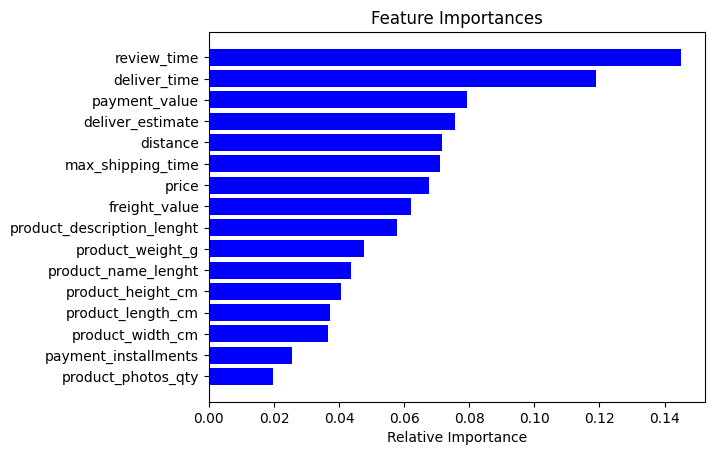

In [ ]:
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Classificação multiclasse

Ao invés da classificação binária, vamos usar o Random Forest para prever diretamente o review score, que tem 5 categorias. O gráfico a seguir mostra a frequência de cada score

<Axes: >

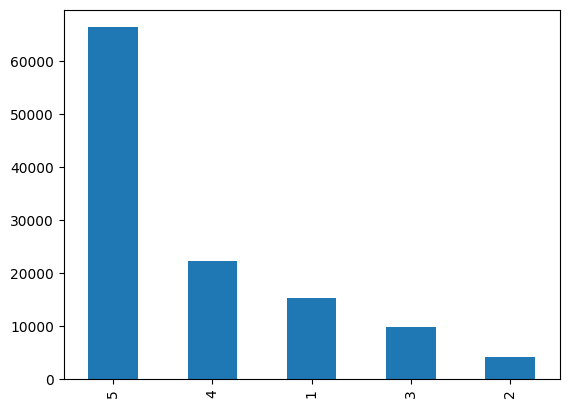

In [ ]:
df['review_score'].value_counts().plot(kind='bar')

Vamos recriar a base de treino e teste, agora usando o `review_score`

In [ ]:
data = df[columns + ['review_score']].dropna(axis = 0, how = 'any')
Xmulti = data[columns]
Ymulti = data['review_score']

Vamos também importar os métodos para calcular e plotar a matriz de confusão:

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


E usar um laço para fazer a validação cruzada estratificada. Em cada iteração do lavo, armazenamos a matriz de confusão daquela iteração, e mostramos o relatório de classificação

In [ ]:
rf = RandomForestClassifier()

confusion_matrices = []

for train, test in skf.split(Xmulti, Ymulti):
  rf.fit(Xmulti.iloc[train],Ymulti.iloc[train])
  predictions = rf.predict(Xmulti.iloc[test])
  print(classification_report(Y.iloc[test], predictions))
  confusion_matrices.append(confusion_matrix(Ymulti.iloc[test],predictions))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5225
           1       0.22      0.02      0.03     17310
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0

    accuracy                           0.01     22535
   macro avg       0.04      0.00      0.01     22535
weighted avg       0.17      0.01      0.03     22535



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5225
           1       0.19      0.01      0.03     17310
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0

    accuracy                           0.01     22535
   macro avg       0.03      0.00      0.00     22535
weighted avg       0.14      0.01      0.02     22535



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5225
           1       0.21      0.02      0.03     17310
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0

    accuracy                           0.01     22535
   macro avg       0.04      0.00      0.01     22535
weighted avg       0.16      0.01      0.02     22535



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5225
           1       0.22      0.02      0.03     17310
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0

    accuracy                           0.01     22535
   macro avg       0.04      0.00      0.01     22535
weighted avg       0.17      0.01      0.02     22535

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5225
           1       0.24      0.02      0.03     17310
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0

    accuracy                           0.01     22535
   macro avg       0.04

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

Finalmente, mostra a matriz de confusão. Como fizemos validação cruzada, a matriz final é a soma de cada uma das matrizes:

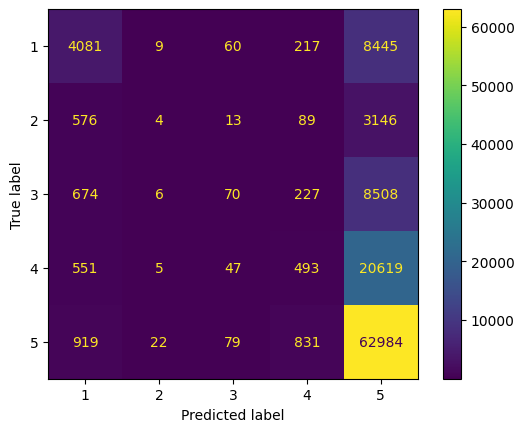

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=sum(confusion_matrices),display_labels=rf.classes_)
disp.plot()